In [25]:
from smartem import smartem,tools
from smartem.online import microscope,get_rescan_maps
from smartem.offline.train_mb_error_detector.NNtools import UNet as UNet_offline
from smartem.offline.train_mb_error_detector.tools import get_error_GT
from smartem.online.models import UNet as UNet_online
from smartem.segmentation import segmenter, utils
import h5py
import numpy as np
from skimage import io, measure, segmentation
from pathlib import Path
import matplotlib.pyplot as plt
import pyvoi
import seaborn as sns
import pandas as pd
from tqdm import tqdm 
import torch
import os
import scipy.ndimage as ndi

In [26]:
hdf5_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"
temp_dir = "/storage2/projects/smartEM/em-vis/temp/"

device = torch.device("cuda:2")

em2mb_model_us = UNet_offline.UNet(1,2)
em2mb_model_core = UNet_online.UNet(1,2)
em2mb_path_us = "../../pretrained_models/em2mb_best.pth"
errnet_path_us = "../../pretrained_models/error_best.pth"
em2mb_path_core = "../../pretrained_models_core/em2mb_best.pth"
errnet_path_core = "../../pretrained_models_core/error_best.pth"

fast_dwt = 50
slow_dwt = 800
rescan_ratios = [0, 0.05, 0.1, 0.25, 0.5, 1.0]
valid_dwts = [25, 50, 75, 100, 125, 150, 200, 300, 400, 500, 600, 800, 1000, 1200]

In [27]:
Iseg_us = segmenter.Segmenter(em2mb_path_us, segmenter_function = segmentation.watershed, device=device)
Iseg_us.set_model(model_class=em2mb_model_us)

Iseg_core = segmenter.Segmenter(em2mb_path_core, segmenter_function = segmentation.watershed, device=device)
Iseg_core.set_model(model_class=em2mb_model_core)

Using watershed function...
Using watershed function...


## Rescan oracle

In [41]:
data_hdt_vois = []
data_re_ratio = []
data_methods = []
data_rescan = []

core = False

with h5py.File(hdf5_path, 'r') as f:
    for reg in tqdm(f.keys(), desc="segmenting regions...", disable=False):
        group = f[reg]
        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - gt_mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # get hdt labels
        slowest_em = group[f"{slowest_dwt}/im"][()]

        hdt_membrane_mask_us, hdt_mb_probs_us = Iseg_us.get_membranes(slowest_em, get_probs=True)
        hdt_mb_probs_us = (hdt_mb_probs_us*255).astype(np.uint8)
        hdt_labels_us = Iseg_us.get_labels(slowest_em)

        if core:
            hdt_membrane_mask_core, hdt_mb_probs_core = Iseg_core.get_membranes(slowest_em, get_probs=True)
            hdt_mb_probs_core = (hdt_mb_probs_core*255).astype(np.uint8)
            hdt_labels_core = Iseg_core.get_labels(slowest_em)

        # acquire
        fast_em = group[f"{fast_dwt}/im"][()]
        slow_em = group[f"{slow_dwt}/im"][()]

        # Rescan
        fdt_labels_us = Iseg_us.get_labels(fast_em)
        mb_mask, mb_probs = Iseg_us.get_membranes(fast_em, get_probs=True)
        mb_probs = (mb_probs*255).astype(np.uint8)
        #rescan_map, _, _ = get_error_GT(mb_probs, hdt_mb_probs_us)
        rescan_map = np.logical_xor(mb_mask, hdt_membrane_mask_us)
        #rescan_map = np.pad(rescan_map, ((4,4),(0,0)))

        # merged_em = fast_em.copy()
        # merged_em[rescan_map] = slowest_em[rescan_map]
        print(f"{np.sum(rescan_map)/rescan_map.size}: {np.sum(merged_em == slow_em)/slow_em.size}")
        # labels_us = Iseg_us.get_labels(merged_em)
        mb_mask[rescan_map] = hdt_membrane_mask_us[rescan_map]
        labels_us = measure.label(255-mb_mask)


        if core:
            fdt_labels_core = Iseg_core.get_labels(fast_em)
            mb_mask, mb_probs = Iseg_core.get_membranes(fast_em, get_probs=True)
            mb_probs = (mb_probs*255).astype(np.uint8)
            #rescan_map = get_error_GT(mb_probs, hdt_mb_probs_core)
            rescan_map = np.logical_xor(mb_mask, hdt_membrane_mask_core)
            rescan_map = np.pad(rescan_map, ((4,4),(0,0)))
            
            print(f"{np.sum(rescan_map)/rescan_map.size}")
            merged_em = fast_em.copy()
            merged_em[rescan_map] = slowest_em[rescan_map]
            labels_core = Iseg_core.get_labels(merged_em)
            #mb_mask[rescan_map] = hdt_membrane_mask_core[rescan_map]
            #labels_core = measure.label(255-mb_mask)
    
        # Compute VI
        voi_gt_us,_,_ = -1, 0, 0 #pyvoi.VI(gt_labels.flatten(), labels_us.flatten())
        voi_hdt_us,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
        voi_hdt_us = voi_hdt_us.item()

        if core:
            voi_gt_core,_,_ = -1, 0, 0 # pyvoi.VI(gt_labels.flatten(), labels_core.flatten())
            voi_hdt_core,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
            voi_hdt_core = voi_hdt_core.item()

        voi,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
        voi = voi.item()
        data_hdt_vois.append(voi)
        data_methods.append(f"Trained @ MIT: {fast_dwt}/{slow_dwt}ns")
        data_rescan.append("Desired rescanning")

        voi,_,_ = pyvoi.VI(hdt_labels_us.flatten(), fdt_labels_us.flatten())
        voi = voi.item()
        data_hdt_vois.append(voi)
        data_methods.append(f"Trained @ MIT: {fast_dwt}/{slow_dwt}ns")
        data_rescan.append("No rescanning")

        if core:
            voi,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
            voi = voi.item()
            data_hdt_vois.append(voi)
            data_methods.append(f"Trained by Core: {fast_dwt}/{slow_dwt}ns")
            data_rescan.append("Replacement")

            voi,_,_ = pyvoi.VI(hdt_labels_core.flatten(), fdt_labels_core.flatten())
            voi = voi.item()
            data_hdt_vois.append(voi)
            data_methods.append(f"Trained by Core: {fast_dwt}/{slow_dwt}ns")
            data_rescan.append("No replacement")

data = {"Method": data_methods, "Variation of Information from Slow Dwell Time Segmentation": data_hdt_vois, "Rescan Status": data_rescan}
df = pd.DataFrame(data=data)

segmenting regions...:   0%|          | 0/18 [00:00<?, ?it/s]

0.02622134140114379: 0.009882177337398374


segmenting regions...:   6%|▌         | 1/18 [00:03<00:55,  3.29s/it]

0.03342077716503268: 0.004538871951219512


segmenting regions...:  11%|█         | 2/18 [00:06<00:51,  3.21s/it]

0.02801202512254902: 0.004371506605691057


segmenting regions...:  17%|█▋        | 3/18 [00:09<00:48,  3.23s/it]

0.03659396701388889: 0.00432958587398374


segmenting regions...:  22%|██▏       | 4/18 [00:12<00:44,  3.20s/it]

0.030201312295751633: 0.004442327235772358


segmenting regions...:  28%|██▊       | 5/18 [00:15<00:41,  3.15s/it]

0.04349596609477124: 0.004382621951219513


segmenting regions...:  33%|███▎      | 6/18 [00:19<00:38,  3.19s/it]

0.033318652982026145: 0.004449631605691057


segmenting regions...:  39%|███▉      | 7/18 [00:22<00:35,  3.21s/it]

0.027521190767973856: 0.004405805386178862


segmenting regions...:  44%|████▍     | 8/18 [00:25<00:32,  3.24s/it]

0.04538079554738562: 0.004568724593495935


segmenting regions...:  50%|█████     | 9/18 [00:29<00:29,  3.25s/it]

0.04273928972630719: 0.0044375635162601625


segmenting regions...:  56%|█████▌    | 10/18 [00:32<00:25,  3.24s/it]

0.02888039981617647: 0.004341971544715447


segmenting regions...:  61%|██████    | 11/18 [00:35<00:22,  3.25s/it]

0.04912683823529412: 0.004356897865853659


segmenting regions...:  67%|██████▋   | 12/18 [00:38<00:19,  3.18s/it]

0.04311363868464052: 0.004540459857723577


segmenting regions...:  72%|███████▏  | 13/18 [00:41<00:15,  3.20s/it]

0.025832631229575163: 0.0043426067073170736


segmenting regions...:  78%|███████▊  | 14/18 [00:45<00:12,  3.21s/it]

0.03737489787581699: 0.0042762322154471545


segmenting regions...:  83%|████████▎ | 15/18 [00:48<00:09,  3.24s/it]

0.04704318576388889: 0.004359756097560976


segmenting regions...:  89%|████████▉ | 16/18 [00:51<00:06,  3.25s/it]

0.03904303257761438: 0.004402629573170731


segmenting regions...:  94%|█████████▍| 17/18 [00:54<00:03,  3.22s/it]

0.031363613153594774: 0.004457888719512195


segmenting regions...: 100%|██████████| 18/18 [00:58<00:00,  3.22s/it]


ValueError: Axes(0.125,0.11;0.775x0.77) has no legend attached.

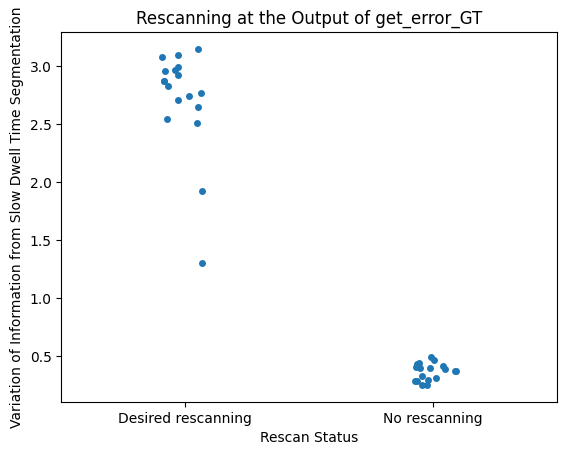

In [42]:
plot = sns.stripplot(data=df, y="Variation of Information from Slow Dwell Time Segmentation", x="Rescan Status")
plot.set(title='Rescanning at the Output of get_error_GT')
sns.move_legend(plot, "upper right")

## Vary rescan ratio

In [8]:
data_hdt_vois = []
data_gt_vois = []
data_re_ratio = []
data_methods = []

with h5py.File(hdf5_path, 'r') as f:
    for rescan_ratio in tqdm(rescan_ratios, desc="varying rescan ratios..."):
        for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
            group = f[reg]
            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            gt_mask = group[f"{slowest_dwt}/mask"][()]
            gt_labels = measure.label(255 - gt_mask)

            if gt_labels.shape[0] % 32 != 0:
                gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
            #print(f"{gt_mask.shape}, {gt_mask.dtype} {np.amin(gt_mask)}-{np.amax(gt_mask)}")

            # get hdt labels
            slowest_em = group[f"{slowest_dwt}/im"][()]
            hdt_labels_us = Iseg_us.get_labels(slowest_em)
            hdt_labels_core = Iseg_core.get_labels(slowest_em)

            image_names = {}

            for dwt in dwts:
                im = group[f"{dwt}/im"][()]
                im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
                if not os.path.isfile(im_file_path):
                    io.imsave(im_file_path, im)

                image_names[dwt] = str(im_file_path)

            params = {"images_ns": image_names}
            my_microscope = microscope.FakeDataMicroscope(params=params)

            # make smartem object
            params = {
                "em2mb_net": em2mb_path_us,
                "error_net": errnet_path_us,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

            my_smart_em_us = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )
            my_smart_em_us.initialize(unet_version="offline")

            params = {
                "em2mb_net": em2mb_path_core,
                "error_net": errnet_path_core,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

            my_smart_em_core = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )
            my_smart_em_core.initialize(unet_version="online")

            # # acquire
            # fast_em = group[f"{fast_dwt}/im"][()]
            # slow_em = group[f"{slow_dwt}/im"][()]
            # # uncertainty
            # _, mb_probs = Iseg_us.get_membranes(fast_em, get_probs=True)
            # mb_certainty = np.abs(0.5 - mb_probs)
            # argmin = np.unravel_index(np.argmin(mb_certainty, axis=None), mb_certainty.shape)
            # r = int(np.sqrt(rescan_ratio * slow_em.size))
            # c = [s // 2 for s in slow_em.shape]
            # rescan_map = np.zeros(slow_em.shape, dtype=bool)
            # rescan_map[c[0]:c[0]+r, c[1]:c[1]+r] = True

            # assert (np.sum(rescan_map) / rescan_map.size) <= rescan_ratio

            # # random
            # # rescan_map_coords = np.random.randint(0, fast_em.shape, size=(int(rescan_ratio*fast_em.size),2))
            # # rescan_map = np.zeros(fast_em.shape, dtype='bool')
            # # for coord in rescan_map_coords:
            # #     rescan_map[coord[0], coord[1]] = True

            # errnet
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, rescan_map, *_ = my_smart_em_us.acquire(params=params)

            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            print(f"{np.sum(rescan_map)/rescan_map.size}: {np.sum(merged_em == slow_em)/slow_em.size}")
            labels_us = Iseg_us.get_labels(merged_em)

            # core
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, rescan_map, *_ = my_smart_em_core.acquire(params=params)
            
            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            print(f"{np.sum(rescan_map)/rescan_map.size}: {np.sum(merged_em == slow_em)/slow_em.size}")
            labels_core = Iseg_core.get_labels(merged_em)
        
            # Compute VI
            voi_gt_us,_,_ = pyvoi.VI(gt_labels.flatten(), labels_us.flatten())
            voi_gt_us = voi_gt_us.item()
            voi_hdt_us,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
            voi_hdt_us = voi_hdt_us.item()
            voi_gt_core,_,_ = pyvoi.VI(gt_labels.flatten(), labels_core.flatten())
            voi_gt_core = voi_gt_core.item()
            voi_hdt_core,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
            voi_hdt_core = voi_hdt_core.item()

            data_gt_vois.append(voi_gt_us)
            data_hdt_vois.append(voi_hdt_us)
            data_re_ratio.append(rescan_ratio)
            data_methods.append(f"SmartEM trained @ MIT: {fast_dwt}/{slow_dwt}ns")

            data_gt_vois.append(voi_gt_core)
            data_hdt_vois.append(voi_hdt_core)
            data_re_ratio.append(rescan_ratio)
            data_methods.append(f"SmartEM Networks from Core: {fast_dwt}/{slow_dwt}ns")


data = {"Method": data_methods, "Variation of Information from GT": data_gt_vois, "Variation of Information from Slow Dwell Time Segmentation": data_hdt_vois, "Rescan Ratio": data_re_ratio}
df = pd.DataFrame(data=data)

varying rescan ratios...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/tommy-local/projects/smartem/SmartEM/smartem/online/get_rescan_maps.py:156: UserWarning: This is very slow in the current implementation.
  warnings.warn("This is very slow in the current implementation.")


0.0: 0.009882177337398374
0.0: 0.009882177337398374
0.0: 0.009707825203252033
0.0: 0.009707825203252033
0.0: 0.009301321138211383
0.0: 0.009301321138211383
0.0: 0.010124491869918699
0.0: 0.010124491869918699
0.0: 0.010309641768292683
0.0: 0.010309641768292683
0.0: 0.009766895325203253
0.0: 0.009766895325203253
0.0: 0.009084413109756098
0.0: 0.009084413109756098
0.0: 0.008944677337398375
0.0: 0.008944677337398375
0.0: 0.0077562881097560975
0.0: 0.0077562881097560975
0.0: 0.008498793191056911
0.0: 0.008498793191056911
0.0: 0.008761115345528455
0.0: 0.008761115345528455
0.0: 0.00840796493902439
0.0: 0.00840796493902439
0.0: 0.009466463414634146
0.0: 0.009466463414634146
0.0: 0.010988630589430894
0.0: 0.010988630589430894
0.0: 0.008611534552845529
0.0: 0.008611534552845529
0.0: 0.008182799796747967
0.0: 0.008182799796747967
0.0: 0.009973958333333333
0.0: 0.009973958333333333
0.0: 0.010322345020325203
0.0: 0.010322345020325203


varying rescan ratios...:  17%|█▋        | 1/6 [02:19<11:38, 139.76s/it]

0.05: 0.059373412093495934
0.05: 0.059367378048780485
0.05: 0.0592822662601626
0.05: 0.059314977134146345
0.05: 0.058818915142276426
0.05: 0.0588598831300813
0.05: 0.05960715193089431
0.05: 0.05964621443089431
0.05: 0.05976467225609756
0.05: 0.05968908790650407
0.05: 0.059243838922764226
0.05: 0.05930735518292683
0.05: 0.05856643800813008
0.05: 0.05859247967479675
0.05: 0.05852896341463415
0.05: 0.05853880843495935
0.05: 0.05735899390243902
0.05: 0.05734533790650406
0.05: 0.058007494918699186
0.05: 0.05808149136178862
0.05: 0.05818470528455284
0.05: 0.05828728404471545
0.05: 0.0579639862804878
0.05: 0.057989075203252034
0.05: 0.058964684959349596
0.05: 0.05897834095528455
0.05: 0.060472560975609754
0.05: 0.060411267784552844
0.05: 0.05813770325203252
0.05: 0.058129763719512194
0.05: 0.057747713414634146
0.05: 0.05772230691056911
0.05: 0.05949314024390244
0.05: 0.05947980182926829
0.05: 0.05973704268292683
0.05: 0.05974815802845528


varying rescan ratios...:  33%|███▎      | 2/6 [04:35<09:09, 137.33s/it]

0.1: 0.1089307037601626
0.1: 0.10890688516260162
0.1: 0.10882780741869919
0.1: 0.10889608739837399
0.1: 0.10836477388211382
0.1: 0.10843908790650407
0.1: 0.10912029979674796
0.1: 0.10917333587398374
0.09999968241869919: 0.10920382367886179
0.1: 0.10910473831300813
0.1: 0.1087423780487805
0.1: 0.10882177337398374
0.1: 0.10808911331300813
0.1: 0.10811166158536585
0.1: 0.10813071646341463
0.1: 0.10813833841463415
0.1: 0.10697535569105691
0.1: 0.106953125
0.1: 0.10761115345528455
0.1: 0.1076781631097561
0.1: 0.10768737296747967
0.1: 0.10787029979674796
0.1: 0.10753556910569105
0.1: 0.10755589430894309
0.1: 0.10849593495934959
0.1: 0.10853118648373984
0.1: 0.1099145706300813
0.1: 0.10987042682926829
0.1: 0.10769213668699187
0.1: 0.10770865091463415
0.1: 0.10732882367886179
0.1: 0.10733263465447154
0.1: 0.10904280995934959
0.1: 0.10898818597560976
0.1: 0.10925622459349593
0.1: 0.10929242886178862


varying rescan ratios...:  50%|█████     | 3/6 [06:46<06:44, 134.70s/it]

0.25: 0.25740917174796746
0.25: 0.2575609756097561
0.2499996824186992: 0.25738916412601626
0.25: 0.25751810213414633
0.25: 0.25688833841463415
0.25: 0.25709159044715446
0.25: 0.2575117505081301
0.25: 0.2578255208333333
0.25: 0.2573774136178862
0.25: 0.25749555386178863
0.2499996824186992: 0.2572411712398374
0.25: 0.25742505081300815
0.25: 0.2566403074186992
0.25: 0.2567647992886179
0.25: 0.2567825838414634
0.25: 0.25688293953252034
0.25: 0.25580729166666666
0.25: 0.2557317073170732
0.25: 0.25640497967479675
0.25: 0.25644118394308946
0.25: 0.25620141006097563
0.25: 0.2565764735772358
0.25: 0.25627985264227643
0.25: 0.25626556148373986
0.25: 0.2571404979674797
0.25: 0.25719385162601627
0.25: 0.25810658028455286
0.25: 0.25832253556910567
0.25: 0.25633130081300814
0.25: 0.25647103658536585
0.25: 0.2561442454268293
0.25: 0.25617790904471544
0.24999904725609756: 0.25752350101626015
0.25: 0.2575860645325203
0.25: 0.25780074949186993
0.25: 0.25798907520325204


varying rescan ratios...:  67%|██████▋   | 4/6 [09:05<04:32, 136.31s/it]

0.4999996824186992: 0.5048005589430894
0.5: 0.5051943597560976
0.5: 0.5046814659552845
0.5: 0.5051356072154471
0.5: 0.5044305767276422
0.5: 0.5048294588414635
0.5: 0.5045296620934959
0.5: 0.5055443343495934
0.5: 0.5045706300813008
0.5: 0.5047754700203252
0.5: 0.5045814278455285
0.5: 0.5051263973577236
0.5: 0.5041164888211382
0.5: 0.5045922256097561
0.5: 0.5042295477642277
0.5: 0.5047084603658537
0.5: 0.5037795350609756
0.5: 0.5037919207317073
0.5: 0.5040977515243903
0.5: 0.5043413363821139
0.5: 0.5038252667682926
0.5: 0.5045156885162602
0.5: 0.503843368902439
0.5: 0.5042555894308943
0.5: 0.5046614583333333
0.5: 0.5049018673780488
0.5: 0.5050863821138212
0.5: 0.5057190040650407
0.4999996824186992: 0.5039923145325204
0.4999996824186992: 0.5044575711382114
0.5: 0.5040059705284553
0.5: 0.5041628556910569
0.5: 0.504757050304878
0.5: 0.5052956681910569
0.4999996824186992: 0.5049701473577236
0.5: 0.5055389354674796


varying rescan ratios...:  83%|████████▎ | 5/6 [11:19<02:15, 135.45s/it]

0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 1.0
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0.9999996824186992: 0.9999996824186992
0

varying rescan ratios...: 100%|██████████| 6/6 [13:32<00:00, 135.43s/it]


[Text(0.5, 1.0, 'SmartEM on Test (Held out) Data with 50/800ns')]

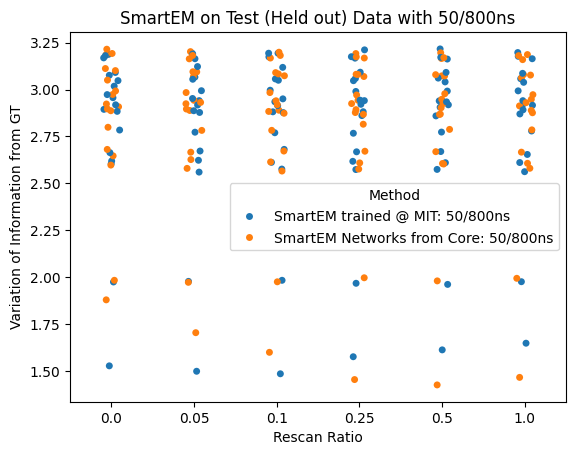

In [18]:
plot = sns.stripplot(data=df, y="Variation of Information from GT", x="Rescan Ratio", hue="Method")
plot.set(title='SmartEM on Test (Held out) Data with 50/800ns')

### Effective dwell time

/home/tommy-local/projects/smartem/SmartEM/results/effective_dwt.csv

In [19]:
data_hdt_vois = []
data_gt_vois = []
data_eff_dwt = []
data_method = []

with h5py.File(hdf5_path, 'r') as f:
    for eff_dwt in tqdm(valid_dwts, desc="varying rescan ratios..."):
        if eff_dwt < fast_dwt or eff_dwt > slow_dwt:
            continue
        # base + rescan_ratio*slow = eff
        rescan_ratio = (eff_dwt - fast_dwt)/slow_dwt
        for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
            group = f[reg]
            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            gt_mask = group[f"{slowest_dwt}/mask"][()]
            gt_labels = measure.label(255 - gt_mask)

            if gt_labels.shape[0] % 32 != 0:
                gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
            #print(f"{gt_mask.shape}, {gt_mask.dtype} {np.amin(gt_mask)}-{np.amax(gt_mask)}")

            im = group[f"{slowest_dwt}/im"][()]
            hdt_labels_us = Iseg_us.get_labels(im)
            hdt_labels_core = Iseg_core.get_labels(im)

            im = group[f"{eff_dwt}/im"][()]
            single_dwt_labels_us = Iseg_us.get_labels(im)
            single_dwt_labels_core = Iseg_core.get_labels(im)

            image_names = {}

            for dwt in dwts:
                im = group[f"{dwt}/im"][()]

                im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
                io.imsave(im_file_path, im)
                image_names[dwt] = str(im_file_path)

            params = {"images_ns": image_names}
            my_microscope = microscope.FakeDataMicroscope(params=params)


            params = {
                "em2mb_net": em2mb_path_us,
                "error_net": errnet_path_us,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map_us = get_rescan_maps.GetRescanMapMembraneErrors(params=params)
            my_smart_em_us = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map_us
            )
            my_smart_em_us.initialize(unet_version="offline")

            params = {
                "em2mb_net": em2mb_path_core,
                "error_net": errnet_path_core,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map_core = get_rescan_maps.GetRescanMapMembraneErrors(params=params)
            my_smart_em_core = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map_core
            )
            my_smart_em_core.initialize(unet_version="online")
            
            # Acquire
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, rescan_map, *_ = my_smart_em_us.acquire(params=params)
            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            labels_us = Iseg_us.get_labels(merged_em)

            fast_em, slow_em, rescan_map, *_ = my_smart_em_core.acquire(params=params)
            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]
            labels_core = Iseg_core.get_labels(merged_em)
        

            data_method.append(f"Our SmartEM {fast_dwt}/{slow_dwt}")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels_us.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_eff_dwt.append(eff_dwt)


            data_method.append(f"Our Single Dwell Time EM2MB")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), single_dwt_labels_us.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_us.flatten(), single_dwt_labels_us.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_eff_dwt.append(eff_dwt)


            data_method.append(f"Core SmartEM {fast_dwt}/{slow_dwt}")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels_core.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_eff_dwt.append(eff_dwt)


            data_method.append(f"Core Single Dwell Time EM2MB")
            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), single_dwt_labels_core.flatten())
            data_gt_vois.append(voi_gt.item())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels_core.flatten(), single_dwt_labels_core.flatten())
            data_hdt_vois.append(voi_hdt.item())
            data_eff_dwt.append(eff_dwt)


data = {f"Effective Dwell Time (ns)": data_eff_dwt, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois, "Method": data_method}
df = pd.DataFrame(data=data)

varying rescan ratios...:   0%|          | 0/14 [00:00<?, ?it/s]/home/tommy-local/projects/smartem/SmartEM/smartem/online/get_rescan_maps.py:156: UserWarning: This is very slow in the current implementation.
  warnings.warn("This is very slow in the current implementation.")
varying rescan ratios...: 100%|██████████| 14/14 [42:37<00:00, 182.68s/it]


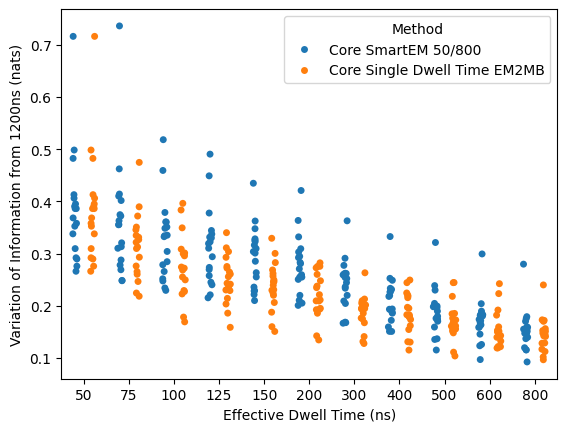

In [21]:
plot = sns.stripplot(data=df[df["Method"].isin(["Core Single Dwell Time EM2MB", "Core SmartEM 50/800"])], y="Variation of Information from 1200ns (nats)", x=f"Effective Dwell Time (ns)", hue="Method", dodge=True)
# plot.set(title='SmartEM on Test (Held out) Data with 50/800ns Dwell Time')

## Visualize

In [56]:
images = {}

with h5py.File(hdf5_path, 'r') as f:
    reg = list(f.keys())[2]

    group = f[reg]
    dwts = [int(dwt) for dwt in list(group.keys())]
    dwts.sort()
    slowest_dwt = dwts[-1]

    gt_mask = group[f"{slowest_dwt}/mask"][()]
    gt_labels = segmentation.watershed(gt_mask)
    #gt_labels = measure.label(255 - gt_mask)

    if gt_labels.shape[0] % 32 != 0:
        gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
        gt_mask = gt_mask[:-(gt_mask.shape[0] % 32), :]
    gt_labels_shuffled = utils.shuffle_labels(gt_labels)
    gt_labels_masked = np.ma.masked_where(gt_labels_shuffled == 0, gt_labels_shuffled)
    gt_labels_masked = np.ma.masked_where(gt_mask > 0.5, gt_labels_masked)

    sdt_im = group[f"{slowest_dwt}/im"][()]
    _, sdt_mb_probs = Iseg_us.get_membranes(sdt_im, get_probs=True)
    sdt_mb_probs = (sdt_mb_probs*255).astype(np.uint8)
    hdt_labels = Iseg_us.get_labels(sdt_im)

    image_names = {}

    for dwt in dwts:
        im = group[f"{dwt}/im"][()]

        im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
        io.imsave(im_file_path, im)
        image_names[dwt] = str(im_file_path)

    params = {"images_ns": image_names}
    my_microscope = microscope.FakeDataMicroscope(params=params)

    for rescan_ratio in tqdm(rescan_ratios, desc="varying rescan ratios..."):
        params = {
            "em2mb_net": em2mb_path_us,
            "error_net": errnet_path_us,
            "device": device,
            "pad": 0,
            "rescan_p_thres": None, # 0.1
            "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
            "search_step": 0.01,
            #"do_clahe": False,
        }
        get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

        my_smart_em = smartem.SmartEM(
            microscope=my_microscope, get_rescan_map=get_rescan_map
        )

        my_smart_em.initialize(unet_version="offline")
        
        params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
        fast_em, slow_em, rescan_map, *_ = my_smart_em.acquire(params=params)
        merged_em = fast_em.copy()
        merged_em[rescan_map] = slow_em[rescan_map]

        _, mb_probs = Iseg_us.get_membranes(merged_em, get_probs=True)
        labels = Iseg_us.get_labels(merged_em)

        labels_shuffled = utils.shuffle_labels(labels)
        labels_masked = np.ma.masked_where(labels_shuffled == 0, labels_shuffled)
        labels_masked = np.ma.masked_where(mb_probs > 0.5, labels_masked)

        mb_probs = (mb_probs*255).astype(np.uint8)
        rescan_map, _, _ = get_error_GT(mb_probs, sdt_mb_probs)
        voi_gt,_,_ = pyvoi.VI(hdt_labels.flatten(), labels.flatten())
    
        title_stem = f"rescan_ratio_{rescan_ratio}_VOI_{voi_gt.item():.2f}"

        images[title_stem + "_image"] = merged_em
        images[title_stem + "_label"] = labels_masked
        images[title_stem + "_pred"] = mb_probs
        


images["ground_truth_image"] = sdt_im
images["ground_truth_label"] = gt_labels_masked
images["ground_truth_pred"] = gt_mask
images["high_dwell_time_image"] = sdt_im


varying rescan ratios...: 100%|██████████| 6/6 [01:47<00:00, 17.96s/it]


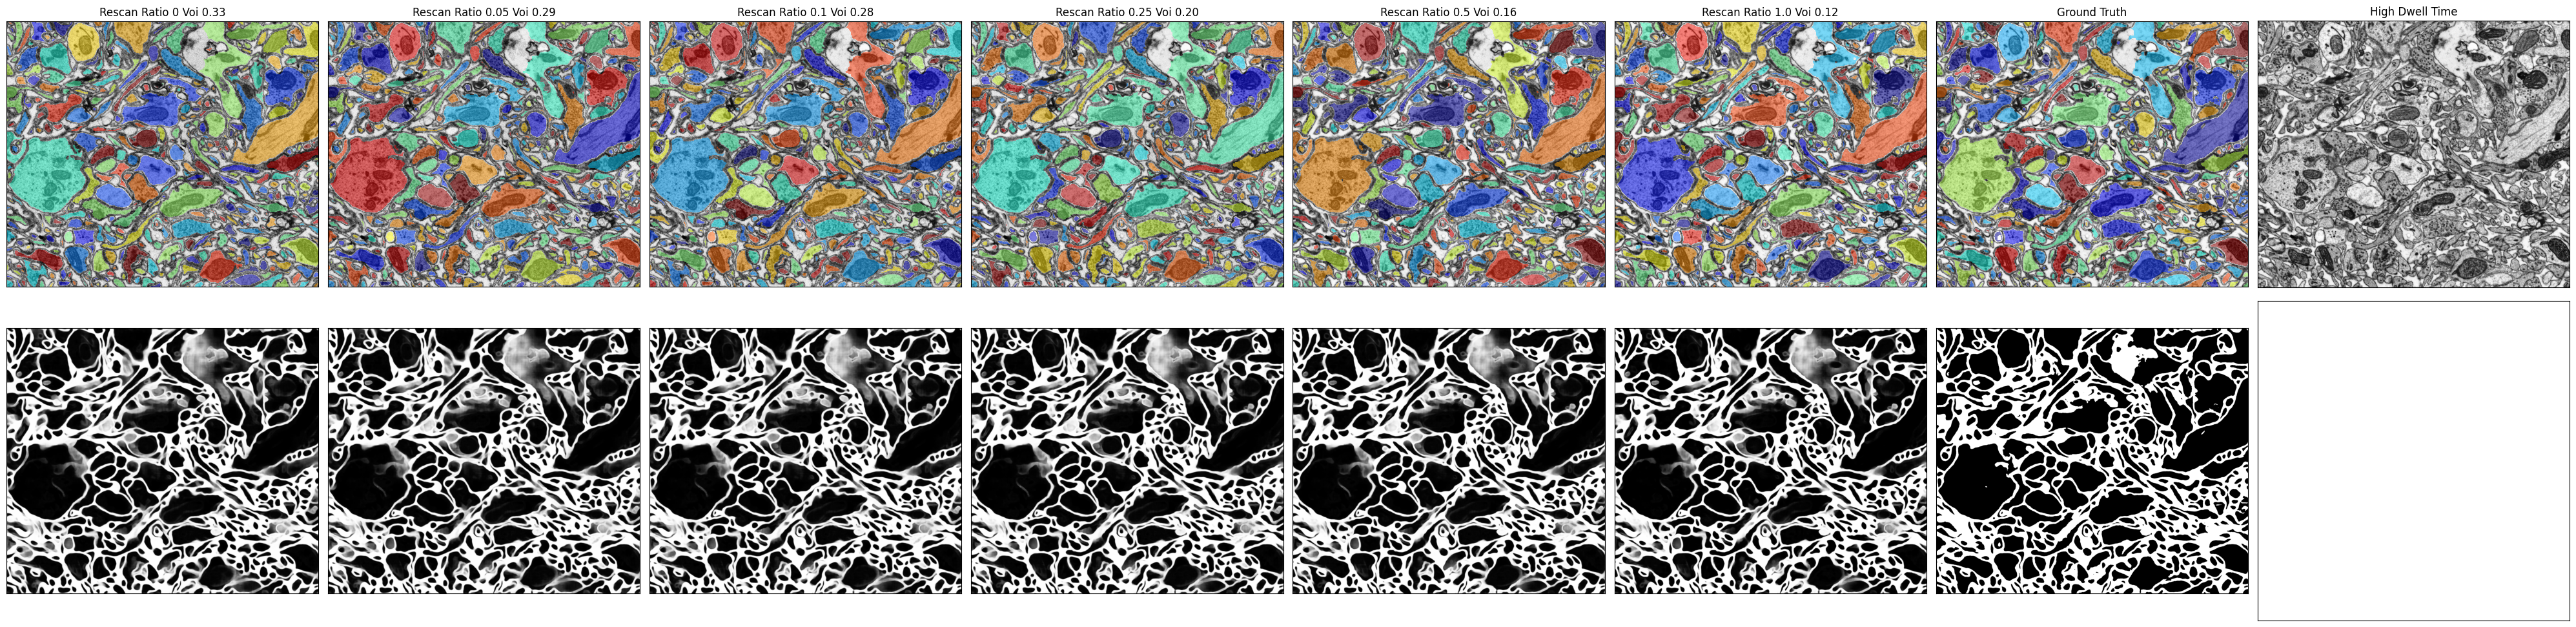

In [57]:
utils.visualize(**images)